In [99]:
# 1.目的
# 最終コーナーの通過順位を予想したものが着番の説明変数として有用なのか確認する（2025/9/22現在、有用ではない）

In [3]:
# インポート
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

In [93]:
# CSVファイルの読み込み
df = pd.read_csv('input_編集後_説明変数追加.csv', encoding='cp932')
print(f"dfの行数は {len(df)} ")
df['race_date'] = pd.to_datetime(df['race_date'])  # 日付が文字列なら変換
# フィルタ条件を適用
filtered_df = df[
    (df['race_date'].dt.year >= 2023) &
    (df['race_date'].dt.year <= 2024)
]
print(f"filtered_dfの行数は {len(filtered_df)} ")
# レースID、馬番順に並び替え
filtered_df = filtered_df.sort_values(by=['race_id', 'horse_number'])
# レースごとの馬のタイム指数の平均値を計算し、タイム指数との差を計算する
race_avg_time_index = filtered_df.groupby('race_id')['time_index_average_1'].transform('mean')
# 平均との差を新しいカラムとして追加
filtered_df['time_index_diff_from_avg'] = filtered_df['time_index_average_1'] - race_avg_time_index
# NaN を除外（最低限のデータ整備）
df = filtered_df.dropna(subset=['race_id', 'position_4', 'style_encoded', 'rank_diff'])
# 分母：各 (pass_rank1, style_encoded) の全体出現数
total_counts = (
    df
    .groupby(['position_4', 'style_encoded'])
    .size()
    .reset_index(name='total')
)
# 分子：
# 各 race_id ごとに rank_diff が最大の行を抽出
idx_max = df.groupby('race_id')['rank_diff'].idxmax()
df_max = df.loc[idx_max, ['position_4', 'style_encoded']]
# その pass_rank1 と style_encoded の組み合わせの出現回数を数える
match_counts = (
    df_max
    .groupby(['position_4', 'style_encoded'])
    .size()
    .reset_index(name='matched')
)
# マージして確率計算
result = pd.merge(total_counts, match_counts, on=['position_4', 'style_encoded'], how='left')
result['matched'] = result['matched'].fillna(0)
result['probability'] = result['matched'] / result['total']
# 結果を表示
print(result.sort_values(by=['style_encoded', 'position_4']).head(32))
print(f"Matched 合計: {result['matched'].sum()}")
print(f"Total 合計: {result['total'].sum()}")
# prob_mapは既に作成済み（position_4, style_encoded をキーにした辞書）
prob_map = result.set_index(['position_4', 'style_encoded'])['probability'].to_dict()
# 学習データと検証データの判定条件（例としてrace_dateで分割）
# ここは適宜調整してください
train_mask = filtered_df['race_date'].dt.year == 2023  # 例: 2023年が学習データ
test_mask = filtered_df['race_date'].dt.year == 2024   # 例: 2024年が検証データ
# 新カラム初期化
filtered_df['probability_of_max_rank_diff'] = np.nan
# 学習データには (position_4, style_encoded) をキーにprobability割り当て
filtered_df.loc[train_mask, 'probability_of_max_rank_diff'] = filtered_df.loc[train_mask].apply(
    lambda row: prob_map.get((row['position_4'], row['style_encoded']), np.nan),
    axis=1
)
# 検証データには (y4_rank, style_encoded) をキーにprobability割り当て
filtered_df.loc[test_mask, 'probability_of_max_rank_diff'] = filtered_df.loc[test_mask].apply(
    lambda row: prob_map.get((row['y4_rank'], row['style_encoded']), np.nan),
    axis=1
)
# 確認
print(filtered_df.loc[train_mask, [
    'race_id', 'horse_number', 'position_4', 'y4_rank', 'style_encoded', 'probability_of_max_rank_diff'
]].head(8))
print(filtered_df.loc[test_mask, [
    'race_id', 'horse_number', 'position_4', 'y4_rank', 'style_encoded', 'probability_of_max_rank_diff'
]].head(8))

dfの行数は 1528 
filtered_dfの行数は 1528 
    position_4  style_encoded  total  matched  probability
0          1.0            1.0     31      2.0     0.064516
4          2.0            1.0     21      0.0     0.000000
8          3.0            1.0     20      0.0     0.000000
12         4.0            1.0      8      0.0     0.000000
16         5.0            1.0     15      1.0     0.066667
20         6.0            1.0      1      0.0     0.000000
24         7.0            1.0      3      0.0     0.000000
28         8.0            1.0      8      0.0     0.000000
1          1.0            2.0     53      4.0     0.075472
5          2.0            2.0     38      0.0     0.000000
9          3.0            2.0     26      1.0     0.038462
13         4.0            2.0     22      2.0     0.090909
17         5.0            2.0     11      0.0     0.000000
21         6.0            2.0     15      0.0     0.000000
25         7.0            2.0     13      0.0     0.000000
29         8.0       

In [95]:
# レースIDの先頭2桁を抽出（文字列として扱う）
filtered_df.loc[:, 'race_id_year'] = filtered_df['race_id'].astype(str).str[:2]
# 件数カウント
count_23 = (filtered_df['race_id_year'] == '23').sum()
count_24 = (filtered_df['race_id_year'] == '24').sum()
# 割合を計算
rate_24 = count_24 / (count_23 + count_24)
# 結果表示
print(f"24の割合: {rate_24:.2f}")
# 説明変数
x = filtered_df[[
    'time_index_diff_from_avg',
    'jockey_place_rate_9',
    'conditional_place_rate_10',
    'probability_of_max_rank_diff'
]]
# 目的変数
y = filtered_df["finish_rank"]
# 学習データと検証データの分割（検証データ割合はrate_24）
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=rate_24, shuffle=False)
# モデルの学習
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(x_train, y_train)
# 予測
y_pred = model.predict(x_test)
# y*_predの評価
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")
# y*_rankの評価
# 予測結果を DataFrame に変換して race_id と紐付け
y_pred_df = pd.DataFrame({
    'race_id': filtered_df.loc[x_test.index, 'race_id'].values,
    'y_pred': y_pred
})
# 各レースごとに予測値の小さい順に順位を振る（昇順）
y_pred_df['y_rank'] = y_pred_df.groupby('race_id')['y_pred'].rank(method='first').astype(int)
# 3. 実着順を追加
y_pred_df['y_actual'] = y_test.values
# 正解率（的中率）の計算と出力
correct_top1_count = ((y_pred_df['y_rank'] == 1) & (y_pred_df['y_actual'] == 1)).sum()
unique_race_count = y_pred_df['race_id'].nunique()
top1_accuracy = correct_top1_count / unique_race_count
print(f"1着予測的中率: {top1_accuracy:.4f} （{correct_top1_count} / {unique_race_count}）")
# 実データを出力して確認
y_pred_df.sort_values(by=['race_id', 'y_actual'], ascending=[True, True]).head(56)

24の割合: 0.48
RMSE: 1.7165
R2 Score: 0.4383
1着予測的中率: 0.5000 （50 / 100）


C:\Users\ryo\AppData\Local\Temp\ipykernel_10956\3236403284.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['23' '23' '23' ... '24' '24' '24']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_df.loc[:, 'race_id_year'] = filtered_df['race_id'].astype(str).str[:2]


,race_id,y_pred,y_rank,y_actual
4,231205Z04,1.444344,1,1
2,231205Z04,3.569852,4,2
1,231205Z04,3.182028,2,3
5,231205Z04,3.500337,3,4
7,231205Z04,6.481007,8,5
3,231205Z04,4.442181,5,6
6,231205Z04,6.084003,7,7
0,231205Z04,6.036061,6,8
9,231210Z07,5.929338,5,1
15,231210Z07,1.795915,1,2


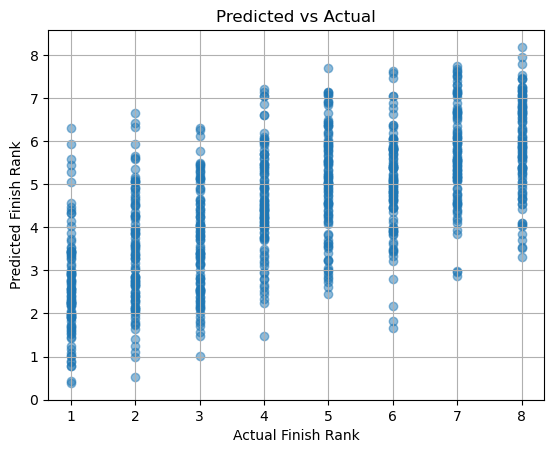

各特徴量の重要度（大きいほど重要）:
                        Feature  Importance
0      time_index_diff_from_avg    0.364032
3  probability_of_max_rank_diff    0.296121
2     conditional_place_rate_10    0.198169
1           jockey_place_rate_9    0.141678


C:\Users\ryo\AppData\Local\Temp\ipykernel_10956\3136151629.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


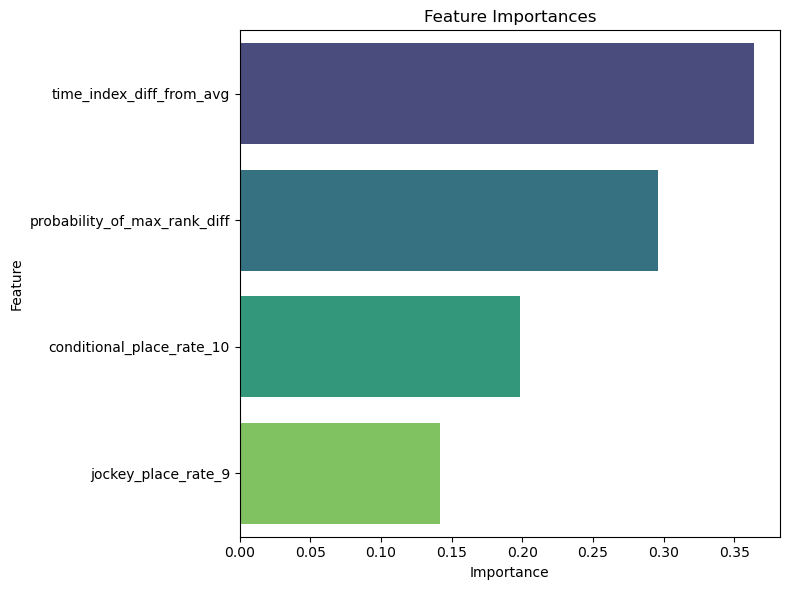

In [97]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
# 予想と正解のプロット
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Finish Rank")
plt.ylabel("Predicted Finish Rank")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()
# 特徴量の重要度
importances = model.feature_importances_
feature_names = x.columns
# DataFrameにしてソート
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print("各特徴量の重要度（大きいほど重要）:")
print(importance_df)
plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
